In [1]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr, spearmanr, ttest_1samp, ttest_ind_from_stats, zscore
from scipy.special import logit
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
rcParams['svg.fonttype'] = 'none'
sns.set(font_scale = 2)
sns.set_style("white")
rcParams['svg.fonttype'] = 'none'

from seaborn import jointplot, scatterplot

from tensorflow.keras.models import Sequential, load_model

In [2]:
dnase_regression = load_model('/projects/pfenninggroup/machineLearningForComputationalBiology/eramamur_stuff/ml_lcl/model_11_hg19_tf.hdf5', compile=False)
dnase_classifier = load_model('/projects/pfenninggroup/machineLearningForComputationalBiology/eramamur_stuff/ml_lcl/classification_model_3_tf.hdf5', compile=False)
mpra_regression = load_model('/projects/pfenninggroup/machineLearningForComputationalBiology/eramamur_stuff/ml_lcl/tewhey_mpra_training/model_8_tf.hdf5', compile=False)

In [3]:
tewhey_ref_sequences = np.load("/projects/pfenninggroup/machineLearningForComputationalBiology/eramamur_stuff/ml_lcl/tewhey_one_hot_encoded_ref_sequences.npy")
tewhey_alt_sequences = np.load("/projects/pfenninggroup/machineLearningForComputationalBiology/eramamur_stuff/ml_lcl/tewhey_one_hot_encoded_alt_sequences.npy")

In [2]:
tewhey_snp_info = pd.read_csv("/projects/pfenninggroup/machineLearningForComputationalBiology/eramamur_stuff/ml_lcl/tewhey_snps_data_extended_joined_to_1kg_mappings_with_1kb_snp_centered_sequences_with_gm_overlaps.txt",
                              sep="\t")

In [ ]:
dnase_regression_ref_scores = dnase_regression.predict(tewhey_ref_sequences)
dnase_regression_alt_scores = dnase_regression.predict(tewhey_alt_sequences)

dnase_classifier_ref_scores = logit(dnase_classifier.predict(tewhey_ref_sequences))
dnase_classifier_alt_scores = logit(dnase_classifier.predict(tewhey_alt_sequences))

mpra_regression_ref_scores = mpra_regression.predict(tewhey_ref_sequences)
mpra_regression_alt_scores = mpra_regression.predict(tewhey_alt_sequences)

In [ ]:
np.save("dnase_regression_ref_scores.npy", dnase_regression_ref_scores)
np.save("dnase_regression_alt_scores.npy", dnase_regression_alt_scores)
np.save("dnase_classifier_ref_scores.npy", dnase_classifier_ref_scores)
np.save("dnase_classifier_alt_scores.npy", dnase_classifier_alt_scores)
np.save("mpra_regression_ref_scores.npy", mpra_regression_ref_scores)
np.save("mpra_regression_alt_scores.npy", mpra_regression_alt_scores)

In [4]:
dnase_regression_ref_scores = np.load("dnase_regression_ref_scores.npy")
dnase_regression_alt_scores = np.load("dnase_regression_alt_scores.npy")
dnase_classifier_ref_scores = np.load("dnase_classifier_ref_scores.npy")
dnase_classifier_alt_scores = np.load("dnase_classifier_alt_scores.npy")
mpra_regression_ref_scores  = np.load("mpra_regression_ref_scores.npy")
mpra_regression_alt_scores  = np.load("mpra_regression_alt_scores.npy")

In [5]:
tewhey_snp_info["Ref.Dnase.Regression"] = dnase_regression_ref_scores
tewhey_snp_info["Alt.Dnase.Regression"] = dnase_regression_alt_scores
tewhey_snp_info["Ref.Dnase.Classifier"] = dnase_classifier_ref_scores
tewhey_snp_info["Alt.Dnase.Classifier"] = dnase_classifier_alt_scores
tewhey_snp_info["Ref.MPRA.Regression"] = mpra_regression_ref_scores
tewhey_snp_info["Alt.MPRA.Regression"] = mpra_regression_alt_scores
tewhey_snp_info["max.allele.logPadj"] = tewhey_snp_info[["C.A.logPadj", "C.B.logPadj"]].max(axis=1)

In [6]:
tewhey_seq_info = pd.DataFrame()

In [7]:
tewhey_seq_info["Dnase.Regression"] = np.concatenate((dnase_regression_ref_scores, dnase_regression_alt_scores)).flatten()
tewhey_seq_info["Dnase.Classifier"] = np.concatenate((dnase_classifier_ref_scores, dnase_classifier_alt_scores)).flatten()
tewhey_seq_info["MPRA.Regression"]  = np.concatenate((mpra_regression_ref_scores, mpra_regression_alt_scores)).flatten()
tewhey_seq_info["log2FC"] = pd.concat([tewhey_snp_info["C.A.log2FC"], tewhey_snp_info["C.B.log2FC"]]).tolist()
tewhey_seq_info["chr"] = pd.concat([tewhey_snp_info["chr"], tewhey_snp_info["chr"]]).tolist()
tewhey_seq_info["active"] = pd.concat([tewhey_snp_info["max.allele.logPadj"]> -np.log10(0.01), tewhey_snp_info["max.allele.logPadj"] > -np.log10(0.01)]).tolist()
tewhey_seq_info["Ctrl.mean"] = pd.concat([tewhey_snp_info["C.A.ctrl.mean"], tewhey_snp_info["C.B.ctrl.mean"]]).tolist()

In [8]:
tewhey_seq_info.shape

(78912, 7)

In [9]:
trainChrs = [17, 11, 19, 12, 5, 22, 9, 21]
validChrs = [3, 7]
testChrs = [1, 6, 10, 4, 2, 16, 20, 15, 8, 14, 18, 13]

In [10]:
tewhey_seq_info["Set"] = tewhey_seq_info["chr"].isin(trainChrs)*0 + tewhey_seq_info["chr"].isin(validChrs)*1 + tewhey_seq_info["chr"].isin(testChrs)*2

In [11]:
#shuffling just to make sure the plotting is fine when we plot train/test/val sets
tewhey_seq_info = tewhey_seq_info.sample(frac=1)

In [12]:
tewhey_seq_info_test = tewhey_seq_info.loc[tewhey_seq_info["Set"].isin([2])]

In [13]:
tewhey_seq_info_test_active = tewhey_seq_info_test.loc[tewhey_seq_info_test["active"]==True]
tewhey_seq_info_test_inactive = tewhey_seq_info_test.loc[tewhey_seq_info_test["active"]==False]

/home/eramamur/bin/miniconda3/envs/keras_tf_new_mar_18_2021/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


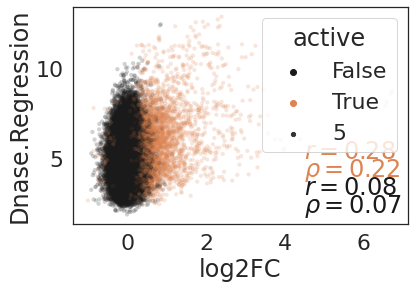

In [14]:
plt.figure(figsize=(6,4))
scatterplot(tewhey_seq_info_test["log2FC"],
            tewhey_seq_info_test["Dnase.Regression"],
            size=5,
            alpha=0.2,
            linewidth=0,
            hue=tewhey_seq_info_test["active"],
            palette=['k', 'C1'],
            rasterized=True
           )


r_active = tewhey_seq_info_test_active[["log2FC", "Dnase.Regression"]].corr(method="pearson")["log2FC"]["Dnase.Regression"]
rho_active = tewhey_seq_info_test_active[["log2FC", "Dnase.Regression"]].corr(method="spearman")["log2FC"]["Dnase.Regression"]
r_inactive = tewhey_seq_info_test_inactive[["log2FC", "Dnase.Regression"]].corr(method="pearson")["log2FC"]["Dnase.Regression"]
rho_inactive = tewhey_seq_info_test_inactive[["log2FC", "Dnase.Regression"]].corr(method="spearman")["log2FC"]["Dnase.Regression"]

plt.text(4.5, 5, 
         r'$r=$'+str(round(r_active, 2)),
         horizontalalignment='left',
         size='medium',
         color='C1'
        )
plt.text(4.5, 4,
         r'$\rho=$'+str(round(rho_active, 2)),
         horizontalalignment='left',
         size='medium',
         color='C1'        )
plt.text(4.5, 3, 
         r'$r=$'+str(round(r_inactive, 2)),
         horizontalalignment='left',
         size='medium',
         color='k'        )
plt.text(4.5, 2,
         r'$\rho=$'+str(round(rho_inactive, 2)),
         horizontalalignment='left',
         size='medium',
         color='k'
        )
plt.savefig("dnase_regression_rna_over_plasmid_vs_predicted_test.svg")

/home/eramamur/bin/miniconda3/envs/keras_tf_new_mar_18_2021/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


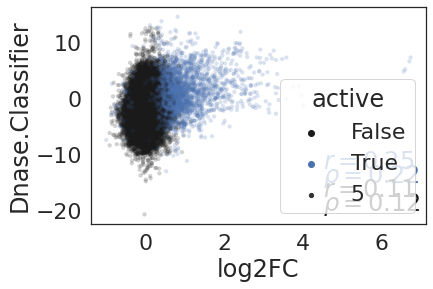

In [15]:
plt.close()
plt.figure(figsize=(6,4))
scatterplot(tewhey_seq_info_test["log2FC"],
            tewhey_seq_info_test["Dnase.Classifier"],
            size=5,
            alpha=0.2,
            linewidth=0,
            hue=tewhey_seq_info_test["active"],
            palette=['k', 'C0'],
            rasterized=True
           )


r_active = tewhey_seq_info_test_active[["log2FC", "Dnase.Classifier"]].corr(method="pearson")["log2FC"]["Dnase.Classifier"]
rho_active = tewhey_seq_info_test_active[["log2FC", "Dnase.Classifier"]].corr(method="spearman")["log2FC"]["Dnase.Classifier"]
r_inactive = tewhey_seq_info_test_inactive[["log2FC", "Dnase.Classifier"]].corr(method="pearson")["log2FC"]["Dnase.Classifier"]
rho_inactive = tewhey_seq_info_test_inactive[["log2FC", "Dnase.Classifier"]].corr(method="spearman")["log2FC"]["Dnase.Classifier"]

plt.text(4.5,-12.5, 
         r'$r=$'+str(round(r_active, 2)),
         horizontalalignment='left',
         size='medium',
         color='C0'
        )
plt.text(4.5,-15,
         r'$\rho=$'+str(round(rho_active, 2)),
         horizontalalignment='left',
         size='medium',
         color='C0'        )
plt.text(4.5,-17.5, 
         r'$r=$'+str(round(r_inactive, 2)),
         horizontalalignment='left',
         size='medium',
         color='k'        )
plt.text(4.5,-20,
         r'$\rho=$'+str(round(rho_inactive, 2)),
         horizontalalignment='left',
         size='medium',
         color='k'
        )


plt.savefig("dnase_classifier_rna_over_plasmid_vs_predicted_test.svg")

In [16]:
tewhey_seq_info_test = tewhey_seq_info_test.sample(frac=1)

/home/eramamur/bin/miniconda3/envs/keras_tf_new_mar_18_2021/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


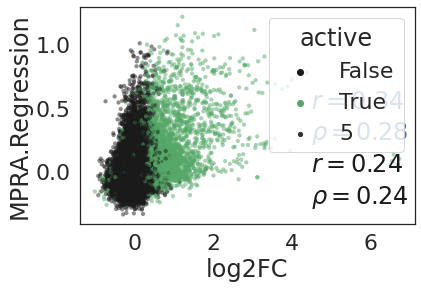

In [29]:
plt.close()
plt.figure(figsize=(6,4))
scatterplot(tewhey_seq_info_test["log2FC"],
            tewhey_seq_info_test["MPRA.Regression"],
            hue = tewhey_seq_info_test["active"],
            palette = ['k', 'C2'],
            linewidth=0,
            size=5,
            alpha=0.5,
            rasterized=True
           )


r_active = tewhey_seq_info_test_active[["log2FC", "MPRA.Regression"]].corr(method="pearson")["log2FC"]["MPRA.Regression"]
rho_active = tewhey_seq_info_test_active[["log2FC", "MPRA.Regression"]].corr(method="spearman")["log2FC"]["MPRA.Regression"]
r_inactive = tewhey_seq_info_test_inactive[["log2FC", "MPRA.Regression"]].corr(method="pearson")["log2FC"]["MPRA.Regression"]
rho_inactive = tewhey_seq_info_test_inactive[["log2FC", "MPRA.Regression"]].corr(method="spearman")["log2FC"]["MPRA.Regression"]



plt.text(4.5,0.5, 
         r'$r=$'+str(round(r_active, 2)),
         horizontalalignment='left',
         size='medium',
         color='C0'
        )
plt.text(4.5,0.25,
         r'$\rho=$'+str(round(rho_active, 2)),
         horizontalalignment='left',
         size='medium',
         color='C0'        )
plt.text(4.5,0, 
         r'$r=$'+str(round(r_inactive, 2)),
         horizontalalignment='left',
         size='medium',
         color='k'        )
plt.text(4.5,-0.25,
         r'$\rho=$'+str(round(rho_inactive, 2)),
         horizontalalignment='left',
         size='medium',
         color='k'
        )

plt.savefig("mpra_regression_rna_over_plasmid_vs_predicted_test.svg")

In [24]:
print(tewhey_seq_info_test.drop(["chr", "Set"], axis=1).corr(method="pearson"))
print(tewhey_seq_info_test.drop(["chr", "Set"], axis=1).corr(method="spearman"))

                  Dnase.Regression  Dnase.Classifier  MPRA.Regression  \
Dnase.Regression          1.000000          0.405026         0.177344   
Dnase.Classifier          0.405026          1.000000         0.414843   
MPRA.Regression           0.177344          0.414843         1.000000   
log2FC                    0.243840          0.264862         0.416004   
active                    0.220616          0.251598         0.343807   
Ctrl.mean                 0.177494          0.351047         0.277375   

                    log2FC    active  Ctrl.mean  
Dnase.Regression  0.243840  0.220616   0.177494  
Dnase.Classifier  0.264862  0.251598   0.351047  
MPRA.Regression   0.416004  0.343807   0.277375  
log2FC            1.000000  0.645053   0.119139  
active            0.645053  1.000000   0.206573  
Ctrl.mean         0.119139  0.206573   1.000000  
                  Dnase.Regression  Dnase.Classifier  MPRA.Regression  \
Dnase.Regression          1.000000          0.379217         0.14

In [26]:
print(tewhey_seq_info_test[["log2FC", "MPRA.Regression"]].corr(method="pearson"))

                   log2FC  MPRA.Regression
log2FC           1.000000         0.416004
MPRA.Regression  0.416004         1.000000


In [27]:
tewhey_snp_info["DNase.Regression.Skew"] = tewhey_snp_info["Alt.Dnase.Regression"] - tewhey_snp_info["Ref.Dnase.Regression"]
tewhey_snp_info["DNase.Classifier.Skew"] = tewhey_snp_info["Alt.Dnase.Classifier"] - tewhey_snp_info["Ref.Dnase.Classifier"]
tewhey_snp_info["MPRA.Regression.Skew"] = tewhey_snp_info["Alt.MPRA.Regression"] - tewhey_snp_info["Ref.MPRA.Regression"]

In [28]:
tewhey_snp_info.columns

Index(['ID', 'SNP', 'Direction', 'Haplotype', 'C.A.ctrl.mean', 'C.A.exp.mean',
       'C.A.log2FC', 'C.A.logP', 'C.A.logPadj', 'C.B.ctrl.mean',
       'C.B.exp.mean', 'C.B.log2FC', 'C.B.logP', 'C.B.logPadj',
       'LogSkew.12878', 'LogSkew.19239', 'LogSkew.Comb', 'C.Skew.logP',
       'C.Skew.fdr', 'tewhey_id', 'chr', '1kg_mapped_id', 'pos', 'hg19_alt',
       'hg19_ref', 'REF.sequence.1kb', 'ALT.sequence.1kb',
       'Num.Overlaps.GM.peaks', 'Ref.Dnase.Regression', 'Alt.Dnase.Regression',
       'Ref.Dnase.Classifier', 'Alt.Dnase.Classifier', 'Ref.MPRA.Regression',
       'Alt.MPRA.Regression', 'max.allele.logPadj', 'DNase.Regression.Skew',
       'DNase.Classifier.Skew', 'MPRA.Regression.Skew'],
      dtype='object')

In [29]:
tewhey_snp_info_test = tewhey_snp_info.loc[tewhey_snp_info["chr"].isin(testChrs)]

In [30]:
tewhey_snp_info_test.shape

(16645, 38)

/home/eramamur/bin/miniconda3/envs/keras_tf_new_mar_18_2021/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


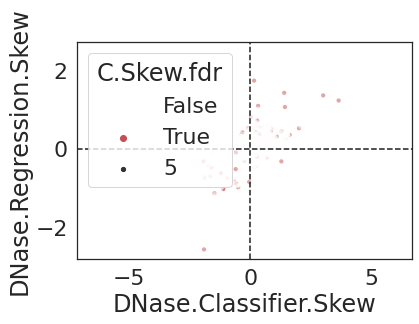

In [31]:
scatterplot(tewhey_snp_info_test["DNase.Classifier.Skew"], tewhey_snp_info_test["DNase.Regression.Skew"], hue=tewhey_snp_info_test["C.Skew.fdr"] > -np.log10(0.01), palette = ['white', 'r'], alpha=0.5,size=5,linewidth=0)
plt.axhline(c='k', linestyle='--')
plt.axvline(c='k', linestyle='--')
plt.show()

/home/eramamur/bin/miniconda3/envs/keras_tf_new_mar_18_2021/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


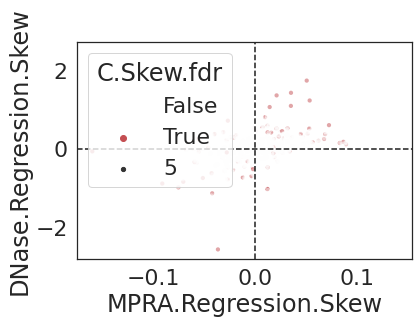

In [32]:
scatterplot(tewhey_snp_info_test["MPRA.Regression.Skew"], tewhey_snp_info_test["DNase.Regression.Skew"], hue=tewhey_snp_info_test["C.Skew.fdr"] > -np.log10(0.01), palette = ['white', 'r'], alpha=0.5,size=5,linewidth=0)
plt.axhline(c='k', linestyle='--')
plt.axvline(c='k', linestyle='--')
plt.show()

/home/eramamur/bin/miniconda3/envs/keras_tf_new_mar_18_2021/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


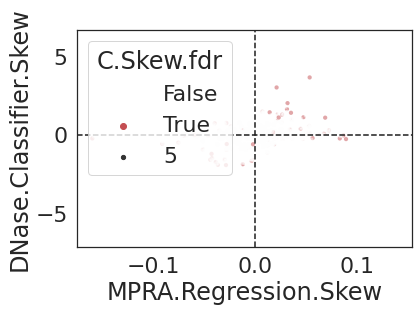

In [33]:
scatterplot(tewhey_snp_info_test["MPRA.Regression.Skew"], tewhey_snp_info_test["DNase.Classifier.Skew"], hue=tewhey_snp_info_test["C.Skew.fdr"] > -np.log10(0.01), palette = ['white', 'r'], alpha=0.5,size=5,linewidth=0)
plt.axhline(c='k', linestyle='--')
plt.axvline(c='k', linestyle='--')
plt.show()

/home/eramamur/bin/miniconda3/envs/keras_tf_new_mar_18_2021/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


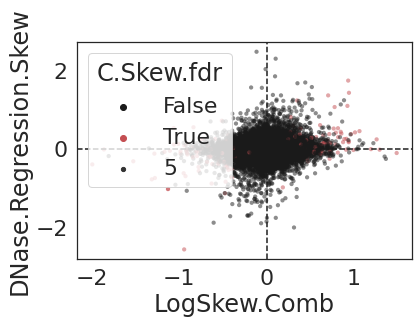

In [34]:
scatterplot(tewhey_snp_info_test["LogSkew.Comb"], tewhey_snp_info_test["DNase.Regression.Skew"], hue=tewhey_snp_info_test["C.Skew.fdr"] > -np.log10(0.01), palette = ['k', 'r'], alpha=0.5,size=5,linewidth=0)
plt.axhline(c='k', linestyle='--')
plt.axvline(c='k', linestyle='--')
plt.show()

/home/eramamur/bin/miniconda3/envs/keras_tf_new_mar_18_2021/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


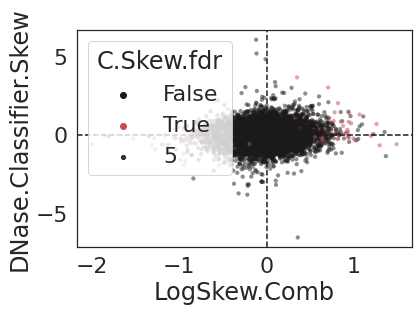

In [35]:
scatterplot(tewhey_snp_info_test["LogSkew.Comb"], tewhey_snp_info_test["DNase.Classifier.Skew"], hue=tewhey_snp_info_test["C.Skew.fdr"] > -np.log10(0.01), palette = ['k', 'r'], alpha=0.5,size=5,linewidth=0)
plt.axhline(c='k', linestyle='--')
plt.axvline(c='k', linestyle='--')
plt.show()

/home/eramamur/bin/miniconda3/envs/keras_tf_new_mar_18_2021/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


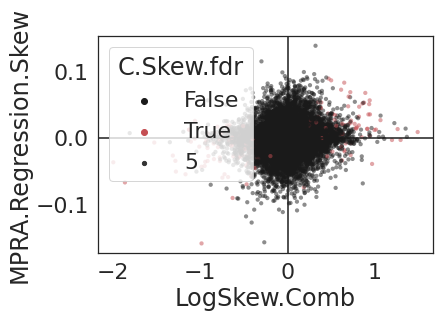

In [36]:
scatterplot(tewhey_snp_info_test["LogSkew.Comb"], tewhey_snp_info_test["MPRA.Regression.Skew"], hue=tewhey_snp_info_test["C.Skew.fdr"] > -np.log10(0.01), palette = ['k', 'r'], alpha=0.5,size=5,linewidth=0)
plt.axhline(c='k')
plt.axvline(c='k')
plt.show()

In [37]:
tewhey_snp_info_test_active = tewhey_snp_info_test.loc[tewhey_snp_info_test["max.allele.logPadj"] > -np.log10(0.01)]

In [38]:
tewhey_snp_info_test_pos = tewhey_snp_info_test_active[(tewhey_snp_info_test_active["C.Skew.fdr"] > -np.log10(0.01)) & (tewhey_snp_info_test_active["LogSkew.Comb"]>0)]
tewhey_snp_info_test_neg = tewhey_snp_info_test_active[(tewhey_snp_info_test_active["C.Skew.fdr"] > -np.log10(0.01)) & (tewhey_snp_info_test_active["LogSkew.Comb"]<0)]
tewhey_snp_info_test_neutral = tewhey_snp_info_test_active[(tewhey_snp_info_test_active["C.Skew.fdr"] < -np.log10(0.01)) & (np.absolute(tewhey_snp_info_test_active["LogSkew.Comb"])<0.2)]

In [39]:
def z_with_center(values, center = 0):
    return (values-center)/np.std(values)

In [40]:
plottables =[z_with_center(tewhey_snp_info_test_neg["DNase.Classifier.Skew"].dropna()).tolist(),
             z_with_center(tewhey_snp_info_test_neg["DNase.Regression.Skew"].dropna()).tolist(),
             z_with_center(tewhey_snp_info_test_neg["MPRA.Regression.Skew"].dropna()).tolist(),
             z_with_center(tewhey_snp_info_test_neutral["DNase.Classifier.Skew"].dropna()).tolist(),
             z_with_center(tewhey_snp_info_test_neutral["DNase.Regression.Skew"].dropna()).tolist(),
             z_with_center(tewhey_snp_info_test_neutral["MPRA.Regression.Skew"].dropna()).tolist(),             
             z_with_center(tewhey_snp_info_test_pos["DNase.Classifier.Skew"].dropna()).tolist(),
             z_with_center(tewhey_snp_info_test_pos["DNase.Regression.Skew"].dropna()).tolist(),
             z_with_center(tewhey_snp_info_test_pos["MPRA.Regression.Skew"].dropna()).tolist()]

In [41]:
print(ttest_1samp(tewhey_snp_info_test_neg["DNase.Classifier.Skew"].dropna().tolist(),0))
print(ttest_1samp(tewhey_snp_info_test_neutral["DNase.Classifier.Skew"].dropna().tolist(),0))
print(ttest_1samp(tewhey_snp_info_test_pos["DNase.Classifier.Skew"].dropna().tolist(),0))
print(ttest_ind_from_stats(np.mean(tewhey_snp_info_test_neg["DNase.Classifier.Skew"].dropna()),
                     np.std(tewhey_snp_info_test_neg["DNase.Classifier.Skew"].dropna()),
                     len(tewhey_snp_info_test_neg["DNase.Classifier.Skew"].dropna().tolist()),
                     np.mean(tewhey_snp_info_test_neutral["DNase.Classifier.Skew"].dropna()),
                     np.std(tewhey_snp_info_test_neutral["DNase.Classifier.Skew"].dropna()),
                     len(tewhey_snp_info_test_neutral["DNase.Classifier.Skew"].dropna().tolist()),
                     equal_var=False))
print(ttest_ind_from_stats(np.mean(tewhey_snp_info_test_pos["DNase.Classifier.Skew"].dropna()),
                     np.std(tewhey_snp_info_test_pos["DNase.Classifier.Skew"].dropna()),
                     len(tewhey_snp_info_test_pos["DNase.Classifier.Skew"].dropna().tolist()),
                     np.mean(tewhey_snp_info_test_neutral["DNase.Classifier.Skew"].dropna()),
                     np.std(tewhey_snp_info_test_neutral["DNase.Classifier.Skew"].dropna()),
                     len(tewhey_snp_info_test_neutral["DNase.Classifier.Skew"].dropna().tolist()),
                     equal_var=False))

Ttest_1sampResult(statistic=-4.56988223723455, pvalue=1.682961533010961e-05)
Ttest_1sampResult(statistic=-0.5173373636171819, pvalue=0.6050321870999019)
Ttest_1sampResult(statistic=4.104580259939137, pvalue=9.106556307852072e-05)
Ttest_indResult(statistic=-4.411228466681842, pvalue=2.8556863439525233e-05)
Ttest_indResult(statistic=4.153084632333905, pvalue=7.264345762834948e-05)


In [42]:
print(ttest_1samp(tewhey_snp_info_test_neg["DNase.Regression.Skew"].dropna().tolist(),0))
print(ttest_1samp(tewhey_snp_info_test_neutral["DNase.Regression.Skew"].dropna().tolist(),0))
print(ttest_1samp(tewhey_snp_info_test_pos["DNase.Regression.Skew"].dropna().tolist(),0))
print(ttest_ind_from_stats(np.mean(tewhey_snp_info_test_neg["DNase.Regression.Skew"].dropna()),
                     np.std(tewhey_snp_info_test_neg["DNase.Regression.Skew"].dropna()),
                     len(tewhey_snp_info_test_neg["DNase.Regression.Skew"].dropna().tolist()),
                     np.mean(tewhey_snp_info_test_neutral["DNase.Regression.Skew"].dropna()),
                     np.std(tewhey_snp_info_test_neutral["DNase.Regression.Skew"].dropna()),
                     len(tewhey_snp_info_test_neutral["DNase.Regression.Skew"].dropna().tolist()),
                     equal_var=False))
print(ttest_ind_from_stats(np.mean(tewhey_snp_info_test_pos["DNase.Regression.Skew"].dropna()),
                     np.std(tewhey_snp_info_test_pos["DNase.Regression.Skew"].dropna()),
                     len(tewhey_snp_info_test_pos["DNase.Regression.Skew"].dropna().tolist()),
                     np.mean(tewhey_snp_info_test_neutral["DNase.Regression.Skew"].dropna()),
                     np.std(tewhey_snp_info_test_neutral["DNase.Regression.Skew"].dropna()),
                     len(tewhey_snp_info_test_neutral["DNase.Regression.Skew"].dropna().tolist()),
                     equal_var=False))

Ttest_1sampResult(statistic=-4.389884086041842, pvalue=3.316877513974677e-05)
Ttest_1sampResult(statistic=-0.1592462982577997, pvalue=0.8735061698388682)
Ttest_1sampResult(statistic=5.143776664418342, pvalue=1.6441826152674706e-06)
Ttest_indResult(statistic=-4.3454129789334885, pvalue=3.765416460548466e-05)
Ttest_indResult(statistic=5.130807776727203, pvalue=1.6025111446364234e-06)


In [43]:
print(ttest_1samp(tewhey_snp_info_test_neg["MPRA.Regression.Skew"].dropna().tolist(),0))
print(ttest_1samp(tewhey_snp_info_test_neutral["MPRA.Regression.Skew"].dropna().tolist(),0))
print(ttest_1samp(tewhey_snp_info_test_pos["MPRA.Regression.Skew"].dropna().tolist(),0))
print(ttest_ind_from_stats(np.mean(tewhey_snp_info_test_neg["MPRA.Regression.Skew"].dropna()),
                     np.std(tewhey_snp_info_test_neg["MPRA.Regression.Skew"].dropna()),
                     len(tewhey_snp_info_test_neg["MPRA.Regression.Skew"].dropna().tolist()),
                     np.mean(tewhey_snp_info_test_neutral["MPRA.Regression.Skew"].dropna()),
                     np.std(tewhey_snp_info_test_neutral["MPRA.Regression.Skew"].dropna()),
                     len(tewhey_snp_info_test_neutral["MPRA.Regression.Skew"].dropna().tolist()),
                     equal_var=False))
print(ttest_ind_from_stats(np.mean(tewhey_snp_info_test_pos["MPRA.Regression.Skew"].dropna()),
                     np.std(tewhey_snp_info_test_pos["MPRA.Regression.Skew"].dropna()),
                     len(tewhey_snp_info_test_pos["MPRA.Regression.Skew"].dropna().tolist()),
                     np.mean(tewhey_snp_info_test_neutral["MPRA.Regression.Skew"].dropna()),
                     np.std(tewhey_snp_info_test_neutral["MPRA.Regression.Skew"].dropna()),
                     len(tewhey_snp_info_test_neutral["MPRA.Regression.Skew"].dropna().tolist()),
                     equal_var=False))

Ttest_1sampResult(statistic=-6.104242811570759, pvalue=3.17129740039791e-08)
Ttest_1sampResult(statistic=-3.011971475526367, pvalue=0.0026591853711168977)
Ttest_1sampResult(statistic=4.806039998233282, pvalue=6.381607597743502e-06)
Ttest_indResult(statistic=-5.269946643478709, pvalue=8.834187050009638e-07)
Ttest_indResult(statistic=5.39755774932448, pvalue=4.789701667761053e-07)


In [44]:
print(ttest_ind_from_stats(np.mean(tewhey_snp_info_test_neg["DNase.Classifier.Skew"].dropna()),
                     np.std(tewhey_snp_info_test_neg["DNase.Classifier.Skew"].dropna()),
                     len(tewhey_snp_info_test_neg["DNase.Classifier.Skew"].dropna().tolist()),
                     np.mean(tewhey_snp_info_test_neg["DNase.Regression.Skew"].dropna()),
                     np.std(tewhey_snp_info_test_neg["DNase.Regression.Skew"].dropna()),
                     len(tewhey_snp_info_test_neg["DNase.Regression.Skew"].dropna().tolist()),
                     equal_var=False))

print(np.mean(tewhey_snp_info_test_neg["DNase.Classifier.Skew"].dropna()))
print(np.mean(tewhey_snp_info_test_neg["DNase.Regression.Skew"].dropna()))

Ttest_indResult(statistic=-1.4658527625658397, pvalue=0.14489954508268968)
-0.33244568
-0.20625918


In [45]:
print(ttest_ind_from_stats(np.mean(tewhey_snp_info_test_pos["DNase.Classifier.Skew"].dropna()),
                     np.std(tewhey_snp_info_test_pos["DNase.Classifier.Skew"].dropna()),
                     len(tewhey_snp_info_test_pos["DNase.Classifier.Skew"].dropna().tolist()),
                     np.mean(tewhey_snp_info_test_pos["DNase.Regression.Skew"].dropna()),
                     np.std(tewhey_snp_info_test_pos["DNase.Regression.Skew"].dropna()),
                     len(tewhey_snp_info_test_pos["DNase.Regression.Skew"].dropna().tolist()),
                     equal_var=False))
print(np.mean(tewhey_snp_info_test_pos["DNase.Classifier.Skew"].dropna()))
print(np.mean(tewhey_snp_info_test_pos["DNase.Regression.Skew"].dropna()))

Ttest_indResult(statistic=1.1147722583363089, pvalue=0.26692146396455424)
0.31498617
0.21783338


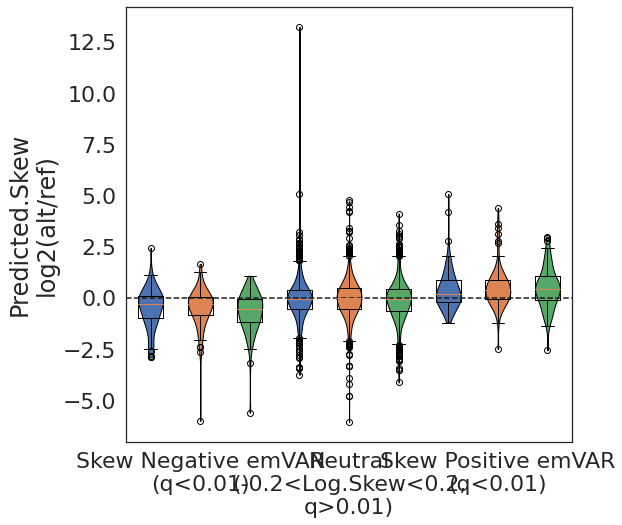

In [46]:
fig, ax = plt.subplots(figsize=(8,8))

parts = ax.violinplot(dataset=plottables,
                               showmedians=False,showextrema=False)

for i in range(0,9,3):
    parts['bodies'][i].set_facecolor('C0')
    parts['bodies'][i].set_edgecolor('black')
    parts['bodies'][i].set_alpha(1)
for i in range(1,9,3):   
    parts['bodies'][i].set_facecolor('C1')
    parts['bodies'][i].set_edgecolor('black')
    parts['bodies'][i].set_alpha(1)    
for i in range(2,9,3):
    parts['bodies'][i].set_facecolor('C2')
    parts['bodies'][i].set_edgecolor('black')
    parts['bodies'][i].set_alpha(1)   

plt.boxplot(plottables)


plt.axhline(y=0, c='k', linestyle='--')
plt.xticks(ticks = range(2,9,3), labels = ["Skew Negative emVAR\n(q<0.01)", "Neutral\n(-0.2<Log.Skew<0.2,\nq>0.01)", "Skew Positive emVAR\n(q<0.01)"], horizontalalignment="center")
plt.ylabel("Predicted.Skew\nlog2(alt/ref)")
plt.savefig("compare_models_q_0.01_emVAR_violin_test_set.svg")
#print(ttest_1samp(train_tewhey_snp_info_neg["Predicted.skew"].tolist(),0))
#print(ttest_1samp(train_tewhey_snp_info_neutral["Predicted.skew"].tolist(),0))
#print(ttest_1samp(train_tewhey_snp_info_pos["Predicted.skew"].tolist(),0))
#print(ttest_ind_from_stats(np.mean(train_tewhey_snp_info_neg["Predicted.skew"]),
#                     np.std(train_tewhey_snp_info_neg["Predicted.skew"]),
#                     len(train_tewhey_snp_info_neg["Predicted.skew"].tolist()),
#                     np.mean(train_tewhey_snp_info_neutral["Predicted.skew"]),
#                     np.std(train_tewhey_snp_info_neutral["Predicted.skew"]),
#                     len(train_tewhey_snp_info_neutral["Predicted.skew"].tolist()),
#                     equal_var=False))
#print(ttest_ind_from_stats(np.mean(train_tewhey_snp_info_pos["Predicted.skew"]),
#                    np.std(train_tewhey_snp_info_pos["Predicted.skew"]),
#                    len(train_tewhey_snp_info_pos["Predicted.skew"].tolist()),
#                    np.mean(train_tewhey_snp_info_neutral["Predicted.skew"]),
#                    np.std(train_tewhey_snp_info_neutral["Predicted.skew"]),
#                    len(train_tewhey_snp_info_neutral["Predicted.skew"].tolist()),
#                    equal_var=False))

In [47]:
print((tewhey_snp_info_test_pos.loc[tewhey_snp_info_test_pos["DNase.Classifier.Skew"]>0]).shape)
print((tewhey_snp_info_test_neg.loc[tewhey_snp_info_test_neg["DNase.Classifier.Skew"]<0]).shape)

print((tewhey_snp_info_test_pos.loc[tewhey_snp_info_test_pos["DNase.Regression.Skew"]>0]).shape)
print((tewhey_snp_info_test_neg.loc[tewhey_snp_info_test_neg["DNase.Regression.Skew"]<0]).shape)

print((tewhey_snp_info_test_pos.loc[tewhey_snp_info_test_pos["MPRA.Regression.Skew"]>0]).shape)
print((tewhey_snp_info_test_neg.loc[tewhey_snp_info_test_neg["MPRA.Regression.Skew"]<0]).shape)

(58, 38)
(60, 38)
(62, 38)
(60, 38)
(64, 38)
(64, 38)


In [48]:
dnase_regression_accuracies = []
dnase_classifier_accuracies = []
mpra_regression_accuracies = []
naive_accuracies = []
q_cutoffs = np.logspace(-3.5,-1,50)

for q_cutoff in q_cutoffs:
    tewhey_snp_info_test_pos = tewhey_snp_info_test_active[(tewhey_snp_info_test_active["C.Skew.fdr"] > -np.log10(q_cutoff)) & (tewhey_snp_info_test_active["LogSkew.Comb"]>0)]
    tewhey_snp_info_test_neg = tewhey_snp_info_test_active[(tewhey_snp_info_test_active["C.Skew.fdr"] > -np.log10(q_cutoff)) & (tewhey_snp_info_test_active["LogSkew.Comb"]<0)]
    tewhey_snp_info_test_neutral = tewhey_snp_info_test_active[(tewhey_snp_info_test_active["C.Skew.fdr"] < -np.log10(q_cutoff)) & (np.absolute(tewhey_snp_info_test_active["LogSkew.Comb"])<0.2)]
    
    dnase_classifier_test_pos_accurate = (tewhey_snp_info_test_pos.loc[tewhey_snp_info_test_pos["DNase.Classifier.Skew"]>0]).shape[0]
    dnase_classifier_test_neg_accurate = (tewhey_snp_info_test_neg.loc[tewhey_snp_info_test_neg["DNase.Classifier.Skew"]<0]).shape[0]
    
    dnase_regression_test_pos_accurate = (tewhey_snp_info_test_pos.loc[tewhey_snp_info_test_pos["DNase.Regression.Skew"]>0]).shape[0]
    dnase_regression_test_neg_accurate = (tewhey_snp_info_test_neg.loc[tewhey_snp_info_test_neg["DNase.Regression.Skew"]<0]).shape[0]

    mpra_regression_test_pos_accurate = (tewhey_snp_info_test_pos.loc[tewhey_snp_info_test_pos["MPRA.Regression.Skew"]>0]).shape[0]
    mpra_regression_test_neg_accurate = (tewhey_snp_info_test_neg.loc[tewhey_snp_info_test_neg["MPRA.Regression.Skew"]<0]).shape[0]

    
    total = tewhey_snp_info_test_pos.shape[0] + tewhey_snp_info_test_neg.shape[0]
    print(q_cutoff,tewhey_snp_info_test_pos.shape[0], tewhey_snp_info_test_neg.shape[0], total)
    
    dnase_classifier_test_accuracy = 1.0*(dnase_classifier_test_pos_accurate+dnase_classifier_test_neg_accurate)/total
    dnase_regression_test_accuracy = 1.0*(dnase_regression_test_pos_accurate+dnase_regression_test_neg_accurate)/total
    mpra_regression_test_accuracy = 1.0*(mpra_regression_test_pos_accurate+mpra_regression_test_neg_accurate)/total
    naive_test_accuracy = 1.0*max(tewhey_snp_info_test_pos.shape[0], tewhey_snp_info_test_neg.shape[0])/total
    
    dnase_classifier_accuracies.append(dnase_classifier_test_accuracy)
    dnase_regression_accuracies.append(dnase_regression_test_accuracy)
    mpra_regression_accuracies.append(mpra_regression_test_accuracy)
    naive_accuracies.append(naive_test_accuracy)

0.00031622776601683794 10 6 16
0.00035564803062231287 10 7 17
0.0003999823395608933 10 8 18
0.0004498432668969444 10 8 18
0.0005059197488435823 11 10 21
0.0005689866029018299 11 13 24
0.0006399152336349266 12 14 26
0.0007196856730011522 14 15 29
0.0008094001216083124 15 15 30
0.0009102981779915217 17 16 33
0.0010237739663395847 20 20 40
0.0011513953993264481 23 22 45
0.0012949258422052632 27 27 54
0.0014563484775012444 29 31 60
0.0016378937069540646 30 36 66
0.0018420699693267163 34 42 76
0.0020716983998953077 39 43 82
0.002329951810515372 41 44 85
0.0026203985288583485 45 48 93
0.0029470517025518097 48 50 98
0.003314424749466425 52 51 103
0.003727593720314938 55 52 107
0.004192267435236918 56 54 110
0.004714866363457394 58 56 114
0.005302611335911987 63 61 124
0.005963623316594642 70 67 137
0.006707035611184306 71 68 139
0.007543120063354623 74 72 146
0.008483428982440725 81 79 160
0.009540954763499945 86 83 169
0.010730309405261566 92 89 181
0.012067926406393288 101 95 196
0.01357228

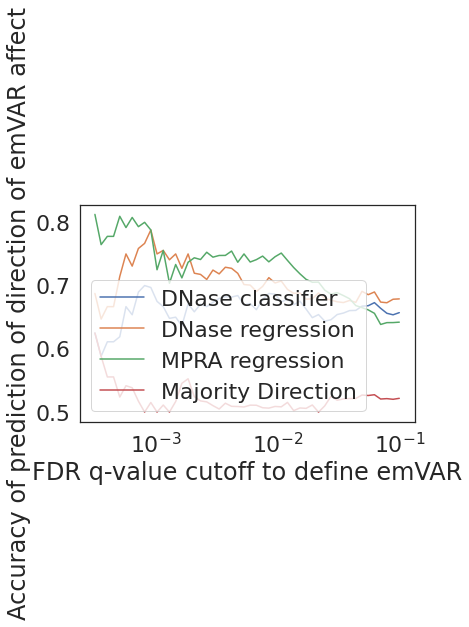

In [49]:
plt.plot(q_cutoffs, dnase_classifier_accuracies, c='C0', label = 'DNase classifier')
plt.plot(q_cutoffs, dnase_regression_accuracies, c='C1', label = 'DNase regression')
plt.plot(q_cutoffs, mpra_regression_accuracies, c='C2', label = 'MPRA regression')
plt.plot(q_cutoffs, naive_accuracies, c='C3', label = 'Majority Direction')
plt.xlabel("FDR q-value cutoff to define emVAR")
plt.ylabel("Accuracy of prediction of direction of emVAR affect")
plt.xscale("log")
plt.legend()
plt.savefig("compare_models_different_q_cutoffs_emvar_test.svg")

/home/eramamur/bin/miniconda3/envs/keras_tf_new_mar_18_2021/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


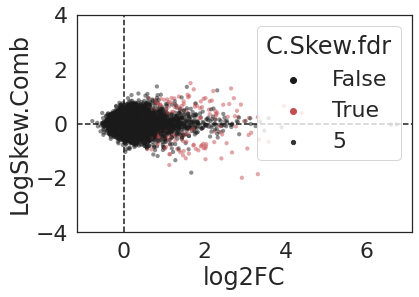

In [50]:
scatterplot(tewhey_snp_info_test[["C.A.log2FC", "C.B.log2FC"]].max(axis=1), tewhey_snp_info_test["LogSkew.Comb"], hue = (tewhey_snp_info_test["C.Skew.fdr"] > -np.log10(0.01)), linewidth=0, palette = ['k', 'r'], alpha=0.5, size=5)

plt.axhline(c='k', linestyle='--')
plt.axvline(c='k', linestyle='--')
plt.xlabel("log2FC")
plt.ylim([-4,4])
plt.savefig("tewhey_rna_over_plasmid_vs_skew_test.svg")

/home/eramamur/bin/miniconda3/envs/keras_tf_new_mar_18_2021/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


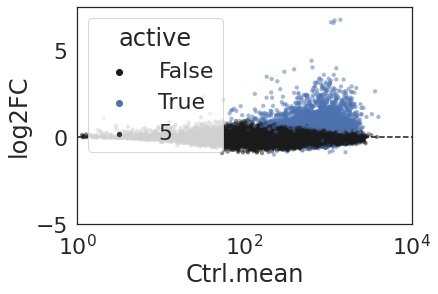

In [51]:
scatterplot(tewhey_seq_info_test["Ctrl.mean"], tewhey_seq_info_test["log2FC"], hue = tewhey_seq_info_test["active"], linewidth=0, palette = ['k', 'C0'], alpha=0.5, size=5)
plt.ylim([-5,7.5])
plt.xscale("log")
plt.xlim([1,1e4])
plt.axhline(c='k', linestyle='--')
plt.savefig("tewhey_plasmid_vs_rna_over_plasmid_test.svg")

In [52]:
allele_freqs_file="/home/eramamur/resources/haploreg_v4.0_20151021_allele_freqs.txt"

In [53]:
allele_freqs = pd.read_csv(allele_freqs_file, sep='\t')

In [54]:
tewhey_snp_info_test_with_allele_freqs = tewhey_snp_info_test.merge(allele_freqs,
                      how='inner',
                      left_on="1kg_mapped_id",
                      right_on="RSID",
                      suffixes=('_1', '_2')
                     )

In [55]:
tewhey_snp_info_test.shape

(22811, 38)

In [55]:
tewhey_snp_info_test_with_allele_freqs.shape

(15553, 43)

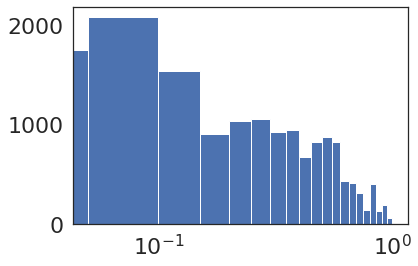

In [56]:
plt.hist(tewhey_snp_info_test_with_allele_freqs["EUR"],
        bins=20)
plt.xscale("log")

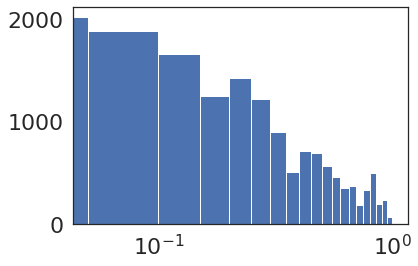

In [57]:
plt.hist(tewhey_snp_info_test_with_allele_freqs["AFR"],
        bins=20)
plt.xscale("log")

In [58]:
tewhey_snp_info_test_with_allele_freqs.columns

Index(['ID', 'SNP', 'Direction', 'Haplotype', 'C.A.ctrl.mean', 'C.A.exp.mean',
       'C.A.log2FC', 'C.A.logP', 'C.A.logPadj', 'C.B.ctrl.mean',
       'C.B.exp.mean', 'C.B.log2FC', 'C.B.logP', 'C.B.logPadj',
       'LogSkew.12878', 'LogSkew.19239', 'LogSkew.Comb', 'C.Skew.logP',
       'C.Skew.fdr', 'tewhey_id', 'chr', '1kg_mapped_id', 'pos', 'hg19_alt',
       'hg19_ref', 'REF.sequence.1kb', 'ALT.sequence.1kb',
       'Num.Overlaps.GM.peaks', 'Ref.Dnase.Regression', 'Alt.Dnase.Regression',
       'Ref.Dnase.Classifier', 'Alt.Dnase.Classifier', 'Ref.MPRA.Regression',
       'Alt.MPRA.Regression', 'max.allele.logPadj', 'DNase.Regression.Skew',
       'DNase.Classifier.Skew', 'MPRA.Regression.Skew', 'RSID', 'AFR', 'AMR',
       'ASN', 'EUR'],
      dtype='object')

In [59]:
rare_tewhey_snp_info_test_with_allele_freqs = tewhey_snp_info_test_with_allele_freqs.loc[tewhey_snp_info_test_with_allele_freqs["EUR"]<0.01]

lowfreq_tewhey_snp_info_test_with_allele_freqs = tewhey_snp_info_test_with_allele_freqs.loc[tewhey_snp_info_test_with_allele_freqs["EUR"]>=0.01]
lowfreq_tewhey_snp_info_test_with_allele_freqs = lowfreq_tewhey_snp_info_test_with_allele_freqs.loc[lowfreq_tewhey_snp_info_test_with_allele_freqs["EUR"]>=0.01]

common_tewhey_snp_info_test_with_allele_freqs = tewhey_snp_info_test_with_allele_freqs.loc[tewhey_snp_info_test_with_allele_freqs["EUR"]>=0.05]

In [60]:
rare_tewhey_snp_info_test_with_allele_freqs.shape

(1348, 43)

In [61]:
lowfreq_tewhey_snp_info_test_with_allele_freqs.shape

(14205, 43)

In [62]:
common_tewhey_snp_info_test_with_allele_freqs.shape

(13803, 43)

In [63]:
rare_tewhey_snp_info_test_with_allele_freqs_sig = rare_tewhey_snp_info_test_with_allele_freqs.loc[rare_tewhey_snp_info_test_with_allele_freqs["C.Skew.fdr"]>-np.log10(0.001)]

lowfreq_tewhey_snp_info_test_with_allele_freqs_sig = lowfreq_tewhey_snp_info_test_with_allele_freqs.loc[lowfreq_tewhey_snp_info_test_with_allele_freqs["C.Skew.fdr"]>-np.log10(0.001)]

common_tewhey_snp_info_test_with_allele_freqs_sig = common_tewhey_snp_info_test_with_allele_freqs.loc[common_tewhey_snp_info_test_with_allele_freqs["C.Skew.fdr"]>-np.log10(0.001)]

In [65]:
rare_tewhey_snp_info_test_with_allele_freqs_sig.shape

(1, 43)

In [66]:
lowfreq_tewhey_snp_info_test_with_allele_freqs_sig.shape

(39, 43)

In [67]:
common_tewhey_snp_info_test_with_allele_freqs_sig.shape

(39, 43)

In [68]:
rare_tewhey_snp_info_test_with_allele_freqs_sig_pos = rare_tewhey_snp_info_test_with_allele_freqs_sig.loc[rare_tewhey_snp_info_test_with_allele_freqs_sig["LogSkew.Comb"]>0]
rare_tewhey_snp_info_test_with_allele_freqs_sig_neg = rare_tewhey_snp_info_test_with_allele_freqs_sig.loc[rare_tewhey_snp_info_test_with_allele_freqs_sig["LogSkew.Comb"]<0]

In [69]:
lowfreq_tewhey_snp_info_test_with_allele_freqs_sig_pos = lowfreq_tewhey_snp_info_test_with_allele_freqs_sig.loc[lowfreq_tewhey_snp_info_test_with_allele_freqs_sig["LogSkew.Comb"]>0]
lowfreq_tewhey_snp_info_test_with_allele_freqs_sig_neg = lowfreq_tewhey_snp_info_test_with_allele_freqs_sig.loc[lowfreq_tewhey_snp_info_test_with_allele_freqs_sig["LogSkew.Comb"]<0]

In [70]:
common_tewhey_snp_info_test_with_allele_freqs_sig_pos = common_tewhey_snp_info_test_with_allele_freqs_sig.loc[common_tewhey_snp_info_test_with_allele_freqs_sig["LogSkew.Comb"]>0]
common_tewhey_snp_info_test_with_allele_freqs_sig_neg = common_tewhey_snp_info_test_with_allele_freqs_sig.loc[common_tewhey_snp_info_test_with_allele_freqs_sig["LogSkew.Comb"]<0]

In [71]:
lowfreq_tewhey_snp_info_test_with_allele_freqs_sig.columns

Index(['ID', 'SNP', 'Direction', 'Haplotype', 'C.A.ctrl.mean', 'C.A.exp.mean',
       'C.A.log2FC', 'C.A.logP', 'C.A.logPadj', 'C.B.ctrl.mean',
       'C.B.exp.mean', 'C.B.log2FC', 'C.B.logP', 'C.B.logPadj',
       'LogSkew.12878', 'LogSkew.19239', 'LogSkew.Comb', 'C.Skew.logP',
       'C.Skew.fdr', 'tewhey_id', 'chr', '1kg_mapped_id', 'pos', 'hg19_alt',
       'hg19_ref', 'REF.sequence.1kb', 'ALT.sequence.1kb',
       'Num.Overlaps.GM.peaks', 'Ref.Dnase.Regression', 'Alt.Dnase.Regression',
       'Ref.Dnase.Classifier', 'Alt.Dnase.Classifier', 'Ref.MPRA.Regression',
       'Alt.MPRA.Regression', 'max.allele.logPadj', 'DNase.Regression.Skew',
       'DNase.Classifier.Skew', 'MPRA.Regression.Skew', 'RSID', 'AFR', 'AMR',
       'ASN', 'EUR'],
      dtype='object')

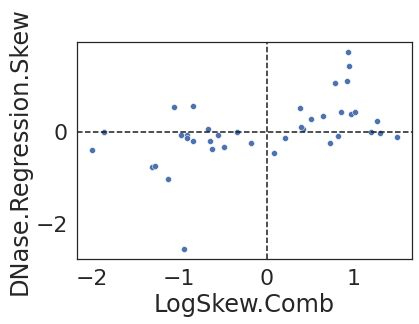

In [72]:
scatterplot(x="LogSkew.Comb",
            y="DNase.Regression.Skew",
            data=common_tewhey_snp_info_test_with_allele_freqs_sig)
plt.axhline(y=0, c='k', linestyle='--')
plt.axvline(x=0, c='k', linestyle='--')

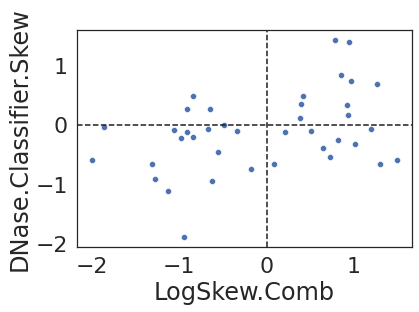

In [73]:
scatterplot(x="LogSkew.Comb",
            y="DNase.Classifier.Skew",
            data=common_tewhey_snp_info_test_with_allele_freqs_sig)
plt.axhline(y=0, c='k', linestyle='--')
plt.axvline(x=0, c='k', linestyle='--')

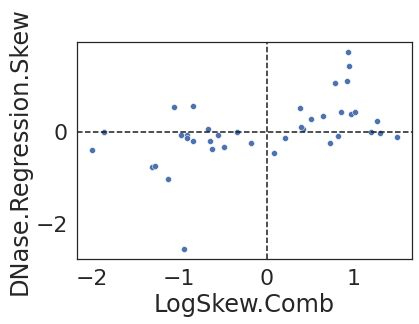

In [74]:
scatterplot(x="LogSkew.Comb",
            y="DNase.Regression.Skew",
            data=lowfreq_tewhey_snp_info_test_with_allele_freqs_sig)
plt.axhline(y=0, c='k', linestyle='--')
plt.axvline(x=0, c='k', linestyle='--')

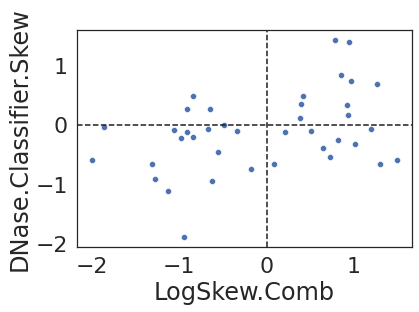

In [75]:
scatterplot(x="LogSkew.Comb",
            y="DNase.Classifier.Skew",
            data=lowfreq_tewhey_snp_info_test_with_allele_freqs_sig)
plt.axhline(y=0, c='k', linestyle='--')
plt.axvline(x=0, c='k', linestyle='--')

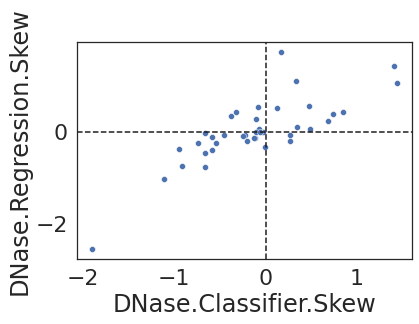

In [76]:
scatterplot(x="DNase.Classifier.Skew",
            y="DNase.Regression.Skew",
            data=lowfreq_tewhey_snp_info_test_with_allele_freqs_sig)
plt.axhline(y=0, c='k', linestyle='--')
plt.axvline(x=0, c='k', linestyle='--')

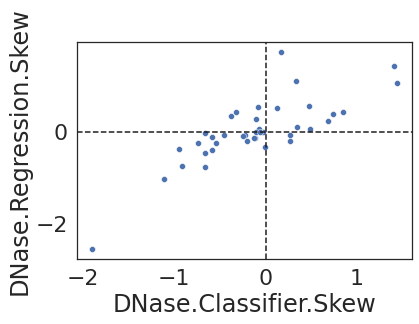

In [77]:
scatterplot(x="DNase.Classifier.Skew",
            y="DNase.Regression.Skew",
            data=common_tewhey_snp_info_test_with_allele_freqs_sig)
plt.axhline(y=0, c='k', linestyle='--')
plt.axvline(x=0, c='k', linestyle='--')

In [78]:
common_tewhey_snp_info_test_with_allele_freqs_sig.loc[common_tewhey_snp_info_test_with_allele_freqs_sig["DNase.Classifier.Skew"]*common_tewhey_snp_info_test_with_allele_freqs_sig["LogSkew.Comb"]>=0].shape

(26, 43)

In [79]:
common_tewhey_snp_info_test_with_allele_freqs_sig.loc[common_tewhey_snp_info_test_with_allele_freqs_sig["DNase.Classifier.Skew"]*common_tewhey_snp_info_test_with_allele_freqs_sig["LogSkew.Comb"]<0].shape

(13, 43)

In [80]:
common_tewhey_snp_info_test_with_allele_freqs_sig.loc[common_tewhey_snp_info_test_with_allele_freqs_sig["DNase.Regression.Skew"]*common_tewhey_snp_info_test_with_allele_freqs_sig["LogSkew.Comb"]>=0].shape

(29, 43)

In [81]:
common_tewhey_snp_info_test_with_allele_freqs_sig.loc[common_tewhey_snp_info_test_with_allele_freqs_sig["DNase.Regression.Skew"]*common_tewhey_snp_info_test_with_allele_freqs_sig["LogSkew.Comb"]<0].shape

(10, 43)

In [82]:
lowfreq_tewhey_snp_info_test_with_allele_freqs_sig.loc[lowfreq_tewhey_snp_info_test_with_allele_freqs_sig["DNase.Classifier.Skew"]*lowfreq_tewhey_snp_info_test_with_allele_freqs_sig["LogSkew.Comb"]>=0].shape

(26, 43)

In [83]:
lowfreq_tewhey_snp_info_test_with_allele_freqs_sig.loc[lowfreq_tewhey_snp_info_test_with_allele_freqs_sig["DNase.Classifier.Skew"]*lowfreq_tewhey_snp_info_test_with_allele_freqs_sig["LogSkew.Comb"]<0].shape

(13, 43)

In [84]:
lowfreq_tewhey_snp_info_test_with_allele_freqs_sig.loc[lowfreq_tewhey_snp_info_test_with_allele_freqs_sig["DNase.Regression.Skew"]*lowfreq_tewhey_snp_info_test_with_allele_freqs_sig["LogSkew.Comb"]>=0].shape

(29, 43)

In [85]:
lowfreq_tewhey_snp_info_test_with_allele_freqs_sig.loc[lowfreq_tewhey_snp_info_test_with_allele_freqs_sig["DNase.Regression.Skew"]*lowfreq_tewhey_snp_info_test_with_allele_freqs_sig["LogSkew.Comb"]<0].shape

(10, 43)